In [47]:
# thomas fermi functions
import numpy as np
import turning_point
reload(turning_point)

def create_K_matrix(x, E_scale=1.0, sigma=1.0, x_0 = 1.0):
    '''
    Input: 
        x : discrete 1D grid
        E_scale : energy scale for the K matrix, default units is eV
        sigma : impact paramter to prevent blow up at the same point
    Output:
        K : matrix of size x.size times x.size

    K(x1,x2) = E_scale / sqrt((x1 - x2)^2 + sigma^2)
    '''
    r = np.abs(x[:,np.newaxis] - x)
    K = E_scale/np.sqrt(r**2 + sigma**2)*np.exp(-r/x_0)
    return K
    
def create_A_matrix(x,V,K,mu_l,N_dot,mask,dot_info,lead_info):
    '''
    Convinience function
    Input:
        x    : discrete 1D grid
        V    : potential
        K    : Coulomb interaction matrix between two points
        mask : array specifying the nature of each point 'l1','d','b' or 'l2'
        dot_info : information about number of dots and their start and end points
    Output:
        A : matrix A used in solution of TF, A z = b 
    '''

    #set up the A matrix
    N_grid = len(x)
    # 2 are leads
    N_D = len(dot_info)
    N_islands = N_D + 2
   
    N_bar = len(filter(lambda x: x == 'b',mask))
    N_A = N_grid + N_islands + N_bar
    A = np.zeros([N_A,N_A])

    A[:N_grid,:N_grid] = K
    # bottom left part
    B = np.zeros((N_D,N_grid))
    # constraint for sum of electron density over a dot
    for i in range(N_D):
        B[i,dot_info[i][0]:dot_info[i][1] + 1] = 1

    # set the sum and mu_dot constraint equations
    A[N_grid:N_grid + N_D,:N_grid] = B
    A[:N_grid,N_grid:N_grid + N_D] = -B.T

    for i in range(len(lead_info)):
        # sum over leads
        A[N_grid + N_D + i,lead_info[i][0]:lead_info[i][1] + 1] = 1
        # minus the unkown electron number on the leads
        A[N_grid + N_D + i,N_grid + N_D + i] = -1
  
    # barrier lagrange multiplier unknowns
    bar_constraint = 0
    for i in range(len(mask)):
        if mask[i] == 'b':
            A[i,N_grid + N_islands + bar_constraint] = -1
            bar_constraint += 1
    # barrier n = 0
    bar_constraint = 0
    for i in range(len(mask)): 
        if mask[i] == 'b':
            A[N_grid + N_islands + bar_constraint,i] = 1 
            bar_constraint += 1
    return A

def create_b_matrix(x,V,K,mu_l,N_dot,mask,dot_info,lead_info):
    '''
    Convinience function
    Input:
        x    : discrete 1D grid
        V    : potential
        K    : Coulomb interaction matrix between two points
        mask : array specifying the nature of each point 'l1','d','b' or 'l2'
        dot_info : information about number of dots and their start and end points
        lead_info : information about leads and their start and end points
        mu_l : (mu_L1, mu_L2) tuple with the lead potentials
        N_dot: vector with number of electrons in each dot, can be of size 0 i.e no dot
    Output:
        b : vector b used in solution of TF, A z = b 
    '''
    N_grid = len(x)
    # 2 are leads
    N_D = len(dot_info)
    N_islands = N_D + 2
    N_bar = len(filter(lambda x: x == 'b',mask))
    
    N_A = N_grid + N_islands + N_bar

    # set up the RHS
    b = np.zeros(N_A)
    b[:N_grid] = -V

    # lead potentials on the RHS
    # notice the all essential +=
    for i in range(len(lead_info)):
        b[lead_info[i][0]:lead_info[i][1] + 1] += mu_l[i] 

    b[N_grid:N_grid+N_D] = N_dot
    return b

def solve_thomas_fermi_iter(x,V,K,mu_l,N_dot):
    '''
    Input:
        x    : discrete 1D grid
        V    : potential
        K    : Coulomb interaction matrix between two points
        mu_l : (mu_L1, mu_L2) tuple with the lead potentials
        N_dot: vector with number of electrons in each dot, can be of size 0 i.e no dot
    Output:
        (n, mu) where
        n    : electronic charge density as a function of x
        mu   : chemical potential as a function of x
               mu(x) = mu_L when x in leads
    
    Solves the Thomas-Fermi equation V - mu + K n = 0 along with the constraint that integral of electron density in a dot is a constant and electron density in the barrier region is zero.
    '''
    #solve the equation A z = b
    # z = (n mu)^T
    N_grid = len(x)
   
    mu_d = [mu_l[0]]*len(N_dot)
    mask_old = []
    mask,lead_info,dot_info = turning_point.get_mask_and_info(V,mu_l,mu_d)
    while(mask_old != mask):
        A = create_A_matrix(x,V,K,mu_l,N_dot,mask,dot_info,lead_info)
        b = create_b_matrix(x,V,K,mu_l,N_dot,mask,dot_info,lead_info)
        z = np.linalg.solve(A,b)
        
        # return the electron density and the dot chemical potentials
        n,mu_d = z[:N_grid],z[N_grid:N_grid + len(dot_info)]
        
        mask_old = mask
        mask,lead_info,dot_info = turning_point.get_mask_and_info(V,mu_l,mu_d)
        
    # also add the
    #lead chemical potentials to simplify further calculations
    mu = np.concatenate(([mu_l[0]],mu_d,[mu_l[1]]))
    return n,mu


def calculate_N_dot_max(x,V,K,mu_l,n_dot):
    '''
     Input:
        x    : discrete 1D grid
        V    : potential
        K    : Coulomb interaction matrix between two points
        mu_l : (mu_L1, mu_L2) tuple with the lead potentials
        n_dot :  number of dots
    Output:
        N_dot
    Assuming all dot_potentials to be equal to the leads, gives the number of electrons on each dot. Right now, the number 
    of dots has to be given as an input.
    '''
    mu_x = np.repeat(mu_l[0],len(V))
    
    # simple tf with lead potential everywhere 
    n = np.linalg.solve(K,mu_x-V)
        
    N_dot = np.zeros(n_dot)
    for i in range(len(dot_info)):
        N_dot[i] = np.sum(n[dot_info[i][0]:dot_info[i][1]+1])
    
    return N_dot
                   

['l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2']


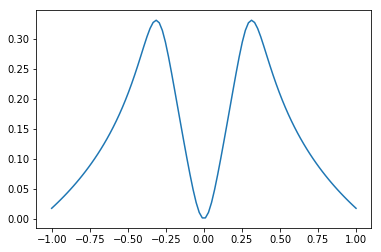

In [15]:
# testing the mask function in turning_point.py

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import potential_profile
reload(potential_profile)
import turning_point
reload(turning_point)

N_grid = 100
x = np.linspace(-1,1,N_grid)

# dot parameters
d = (200e-3,0,0.1,1)
b1 = (-200e-3,-0.3,0.1,1)
b2 = (-200e-3,0.3,0.1,1)

V = potential_profile.single_dot_V_x_wire(x,d,b1,b2)
plt.plot(x,V)

mu_l = (100e-3,100e-3)
mu_d = [100e-3]

mask,lead_info,dot_info = turning_point.get_mask_and_info(V,mu_l,mu_d)

print mask

0.139467679745
0.373393043647
0.276597959381


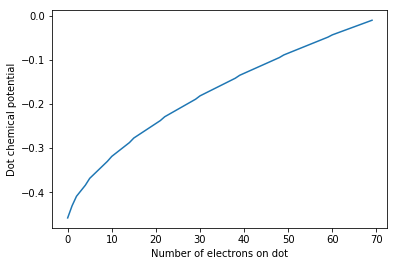

In [65]:
# testing the iterative mask tf solver

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import potential_profile
reload(potential_profile)
import turning_point
reload(turning_point)
from IPython import display
import time

N_grid = 100
x = np.linspace(-1,1,N_grid)

# dot parameters
d = (400e-3,0,0.1,1)
b1 = (-200e-3,-0.3,0.1,1)
b2 = (-200e-3,0.3,0.1,1)

V = potential_profile.single_dot_V_x_wire(x,d,b1,b2)
K = create_K_matrix(x,E_scale=1e-3,sigma=x[1]-x[0],x_0 = 1*(x[1]-x[0]))

mu_l = (100e-3,100e-3)

n_dot = 1
# estimate on dot capacity
N_dot_max = calculate_N_dot_max(x,V,K,mu_l,n_dot)
mu_vec =[]
for i in range(int(N_dot_max[0] + 10)):
    N_dot = [i]
    n,mu = solve_thomas_fermi_iter(x,V,K,mu_l,N_dot)
    mu_vec += [mu[1]]
    
plt.plot(mu_vec)
plt.xlabel('Number of electrons on dot')
plt.ylabel('Dot chemical potential')

print mu_vec[10] - mu_vec[0]
print mu_vec[50] - mu_vec[0]
print mu_vec[30]- mu_vec[0]

Automatic pdb calling has been turned ON
